In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.optim as optim

import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from images_show import ImageShow
from model611 import FixCapsNet

In [ ]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "COVID-19"#"HAM10000"#"ISIC2019"#"skin_lesion"#
best_acc= 0.
T_acc=0.

#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [ ]:
data_transform = {
    "train": transforms.Compose([#transforms.RandomResizedCrop((299, 299)),
                                 #transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "test": transforms.Compose([#transforms.Resize((312, 312)),
                               #transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }
train_doc = "train611"
val_doc = "val611"
test_doc = "test611"

In [56]:
data_root = os.path.abspath(os.path.join(os.getcwd()))  # get data root path
image_path = os.path.join(data_root, "datasets")#
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                     transform=data_transform["train"])
val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                        transform=data_transform["test"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                        transform=data_transform["test"])

train_num = len(train_dataset)
val_num = len(val_dataset)
test_num = len(test_dataset)

# img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = 3#np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes } classes.')
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)
    
BatchSize = 168#128#188
V_size = 32
T_size = 32
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 4]) 
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                           pin_memory=pin_memory,
                                           shuffle=True,num_workers=nw)
val_loader = DataLoader(val_dataset,batch_size=V_size,
                                           pin_memory=pin_memory,
                                           shuffle=False,num_workers=nw)
test_loader = DataLoader(test_dataset,batch_size=T_size,
                                          pin_memory=pin_memory,
                                          shuffle=False,num_workers=nw)

print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,val_num, test_num))
# using 19050 images for training, 2115 images for validation. 97.92-DS
# using 34294 images for training, 2115 images for validation. 98.298-DS
#using 34294 images for training, 1904 images for validation, 2115 images for testing.

Using 4 classes.
Using 4 dataloader workers every process.
using 34294 images for training, 1904 images for validation, 2115 images for testing.


In [ ]:
# Create capsule network.
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

In [ ]:
print("%s | %s | %s" % ("Model", "Params(M)", "FLOPs(G)"))
print("---|---|---")
name = "FixCaps"
dsize = (1, 3, 299, 299)
inputs = torch.randn(dsize).to(device)
total_ops, total_params = profile(network, (inputs,), verbose=False)
print(
    "%s | %.2f | %.2f" % (name, total_params / (1000 ** 2), total_ops / (1000 ** 3))
    )
#FLOPs(G)--> 0.07(0.08).

In [ ]:
network.Convolution

In [ ]:
# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

In [53]:
def confusion_matrix(evl_result):
    plt.figure(figsize=(16,12))
    sb = range(n_classes)
    sns.heatmap(evl_result,annot=True,cmap="Blues",cbar=True,fmt="g", annot_kws={"size": 20})
    plt.yticks([index + 0.5 for index in sb],cla_dict.values(),fontsize=16)
    plt.xticks([index + 0.5 for index in sb],cla_dict.values(),fontsize=16)

    plt.title("Confusion Matrix",fontsize=24)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=16)
    # vname = lambda v,nms: [ vn for vn in nms if id(v)==id(nms[vn])][0]
    # kn = vname(evl_result,locals())
    if evl_result.sum().item() == len(test_loader):
        kn = 'test'
    else:
        kn = 'val'
        
    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion_Matrix_{kn}.png",dpi=300)

In [ ]:
def self_scores(evl_result):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']    
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))  
    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#列和
        recall = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#行和torch.sum(result_table[i])
        F1 = pre * recall * 2 / (pre + recall + 1e-8)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recall, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

In [ ]:
def train(epoch):
    network.train()
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    
    optimizer.zero_grad()
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = to_one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        
        output = network(data)
        loss = network.loss(output, target, size_average=True)
        
        loss.backward()

        if mode == 'DS2':
            if batch_idx % 2 == 0:
                optimizer.step()
                optimizer.zero_grad()
                # scheduler.step()#AdamW
        else:
            optimizer.step()
            optimizer.zero_grad()
            # scheduler.step()#AdamW
            
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}%".format(batch_idx,len(train_loader),loss,
                                                         r_pre/(batch_idx*BatchSize)))
           
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    
    scheduler.step()
    print(f'Train Epoch: [{epoch}] Loss: {epoch_loss},Train_acc:{round(float(epoch_acc),3)}')

In [ ]:
def test(split=None):
    network.eval()
    global T_acc,best_acc,test_evl_result,val_evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = to_one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = data_num % T_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result) 
    accuracy = 100. * float(torch.div(diag_sum,all_sum)) 
    print(f"{split}_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")
    
    if split == 'val':
        val_acc_list.append(accuracy)
        if accuracy >= best_acc:
            best_acc = accuracy
            val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), save_PATH)
            torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
    else:
        test_acc_list.append(accuracy)
        if accuracy >= T_acc:
            best_acc = accuracy
            test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
            torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
        
    print(f"Best_ACC:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")

In [ ]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    !mkdir -p ./tmp/{img_title}/{suf} 
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
print(save_PATH)

In [ ]:
num_epochs = 200

In [ ]:
learning_rate = 0.123
def_betas=(0.9, 0.999)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(network.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

#base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0,
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
#                         steps_per_epoch=len(train_loader),
#                         epochs=num_epochs)

In [ ]:
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')

print('Finished Training')

In [57]:
network.load_state_dict(torch.load(save_PATH))
# model_weight_path = "Best_DS_9613.pth"
# pre_weights = torch.load(model_weight_path, map_location=device)
# pre_dict = {k: v for k, v in pre_weights.items() if network.state_dict()[k].numel() == v.numel()}
# missing_keys, unexpected_keys = network.load_state_dict(pre_dict, strict=False)
for i in range(5):   
    test('test')

COVID-19 ==> test ...


  0%|          | 0/67 [00:00<?, ?it/s]

test_Acc:99.433%
Best_ACC：[99.433%]
COVID-19 ==> test ...


  0%|          | 0/67 [00:00<?, ?it/s]

test_Acc:99.433%
Best_ACC：[99.433%]
COVID-19 ==> test ...


  0%|          | 0/67 [00:00<?, ?it/s]

test_Acc:99.433%
Best_ACC：[99.433%]
COVID-19 ==> test ...


  0%|          | 0/67 [00:00<?, ?it/s]

test_Acc:99.433%
Best_ACC：[99.433%]
COVID-19 ==> test ...


  0%|          | 0/67 [00:00<?, ?it/s]

test_Acc:99.433%
Best_ACC：[99.433%]


In [58]:
show.conclusion(img_title=img_title)

=================Conclusion====================
Dataset:[COVID-19]
Best_Epoch [7]
[Test] ACC:99.43%.


In [20]:
torch.cuda.memory.empty_cache()

In [21]:
self_scores(val_evl_result)

+---------+-----------+--------+-------+----------+
|   Type  | Precision | Recall |   F1  | Accuracy |
+---------+-----------+--------+-------+----------+
|  covid  |   0.9938  | 0.991  | 0.992 |          |
|  normal |   0.9924  | 0.995  | 0.993 |          |
| opacity |   0.9907  | 0.989  |  0.99 |          |
|  viral  |   0.9915  | 0.992  | 0.992 |          |
|  Total: |           |        |       |  0.9921  |
+---------+-----------+--------+-------+----------+


In [59]:
self_scores(test_evl_result)

+---------+-----------+--------+-------+----------+
|   Type  | Precision | Recall |   F1  | Accuracy |
+---------+-----------+--------+-------+----------+
|  covid  |   0.9918  |  1.0   | 0.996 |          |
|  normal |    1.0    | 0.988  | 0.994 |          |
| opacity |   0.9852  |  1.0   | 0.993 |          |
|  viral  |    1.0    |  1.0   |  1.0  |          |
|  Total: |           |        |       |  0.9943  |
+---------+-----------+--------+-------+----------+


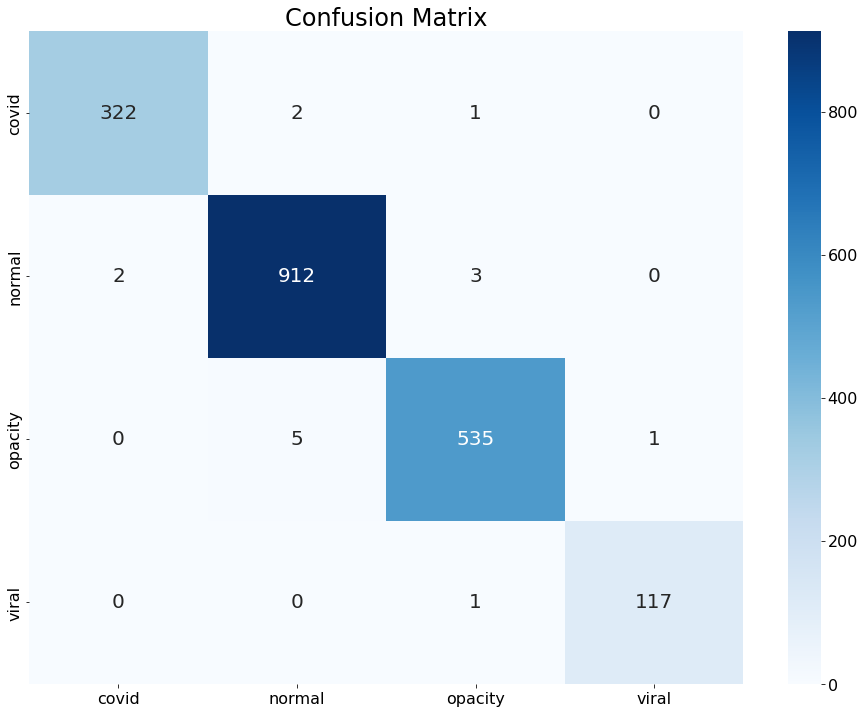

In [23]:
confusion_matrix(val_evl_result)

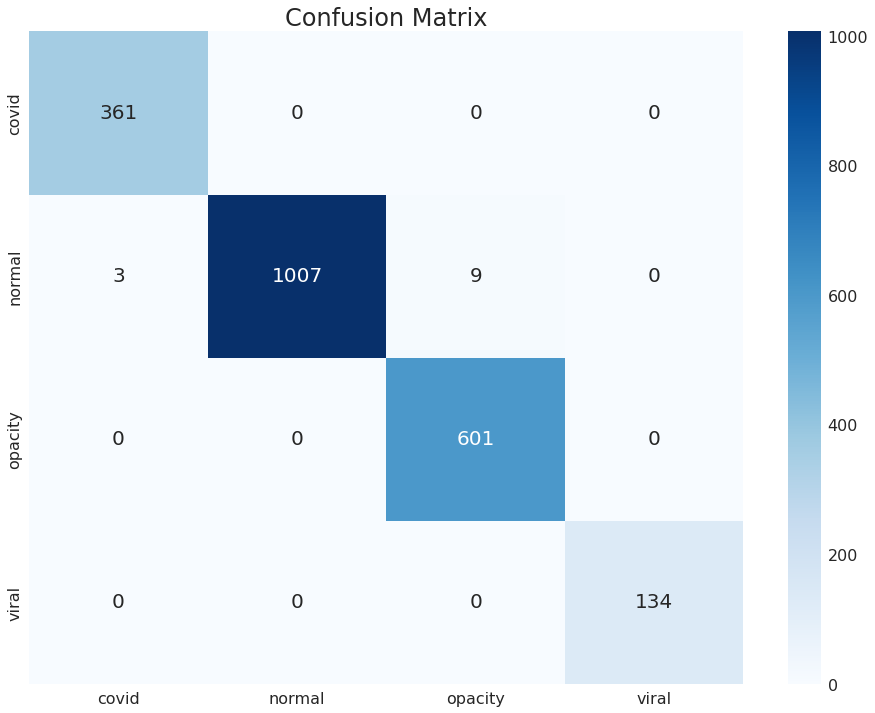

In [60]:
confusion_matrix(test_evl_result)

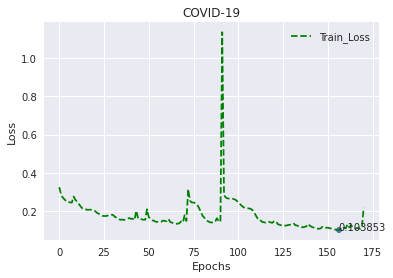

In [25]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

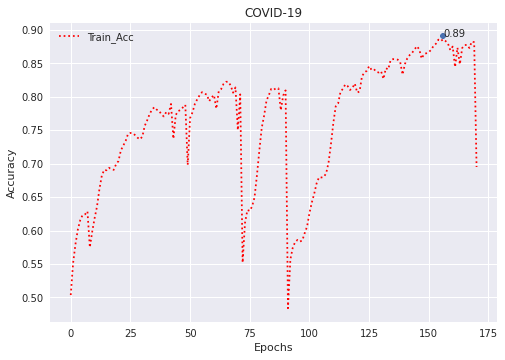

In [26]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

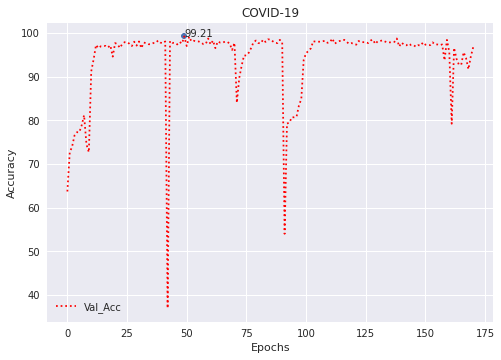

In [27]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [28]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)